# House Price Prediction System

**Importing Libraries** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from xgboost import XGBRegressor

C:\Users\USER\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**the DataSet downloaded from the Kaggle competition**<br>
__https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data__

In [2]:
df = pd.read_csv(r"d:\Users\USER\Desktop\Property\HousePrices.csv")
df=pd.DataFrame(df)
df.shape

(1460, 81)

## Exploratory Data Analysis

TO Check Null Value Percentage

In [3]:
def nllval(data):
    cname=(data.isnull().sum().sort_values(ascending = False))/len(df)*100
    print(cname.head(20))

In [4]:
nllval(df)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64


Though PoolQuality(92.52%) and MiscellaneousFeature(96.30%) have Null Value that might Mean dont have that Feature we shall that part in Featuring Engineering

#### Lets plot the Correaltion HeatMap

<AxesSubplot:>

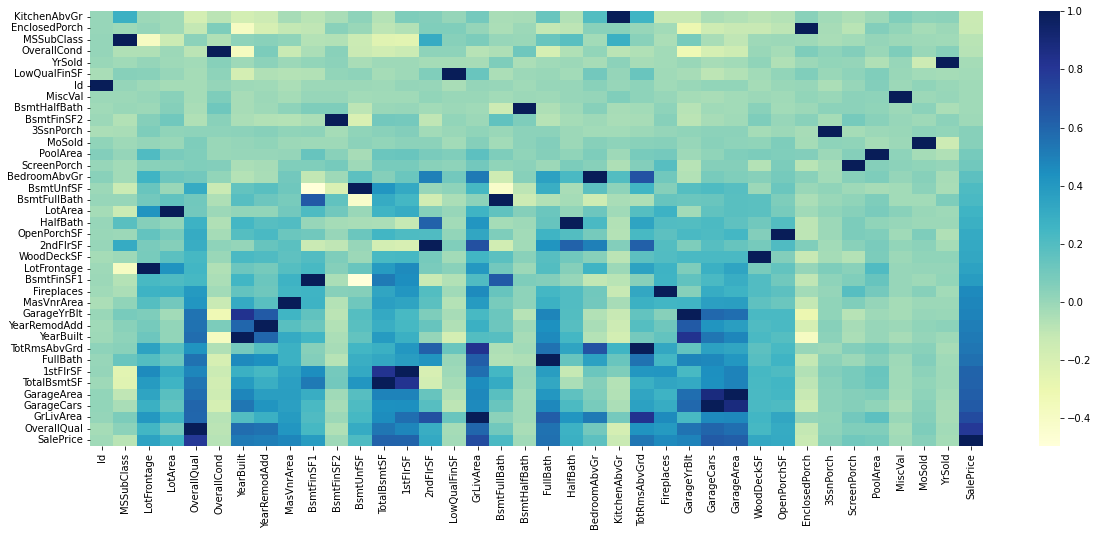

In [5]:
plt.figure(figsize=(20,8))
sns.heatmap((df.corr().sort_values('SalePrice')),cmap="YlGnBu")  # Diagnol Line will be Disturbuig


**Top 5 Highly Correlated Features With the SalePrice are:**
1. OverallQual
2. GrLivArea
3. GarageCars
4. GarageArea
5. TotalBsmtSF

**Remove the column which are highly correlated with eath other**

In [6]:
def similar_clounmn(df,thresold):
    cormat = df.corr()
    setcol = set()
    for i in range(len(cormat)):
        for j in range(i):
            if abs(cormat.iloc[i,j]) > thresold:
                setcol.add(cormat.columns[i])
    return setcol

In [7]:
reove=similar_clounmn(df,0.7)
reove=set(reove)

reove

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'SalePrice', 'TotRmsAbvGrd'}

Creating Seperate Variable for Dependent Variable i.e **SalePrice**

In [8]:
x=df.drop('SalePrice',axis=1)
y=df['SalePrice']


In [9]:
reove=similar_clounmn(x,0.7)
reove=set(reove)
x.drop(reove,axis=1,inplace=True)
x.shape

(1460, 76)

Splitting dataset into train(90%) and  test(10%)

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split( x,y,test_size=0.1,random_state=2)
x.shape,x_train.shape,x_test.shape

((1460, 76), (1314, 76), (146, 76))

In [11]:
def objectcolumns(df,graph):
    deke=set()
    for i in df:
        if df[i].dtype == 'O':
            if len(df[i].unique()) < 10:
                deke.add(i)
                if graph == 1:
                    df[i].value_counts().plot(kind='bar')
                    plt.ylabel('Count')
                    plt.xlabel(i)
                    plt.show()
    return deke

import warnings
warnings.filterwarnings('ignore')

In [12]:
objects=objectcolumns(x_train,0)
objects
x_train[objects].isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1308
MiscFeature     1262
Alley           1229
Fence           1060
FireplaceQu      627
GarageFinish      75
GarageType        75
GarageQual        75
GarageCond        75
BsmtExposure      34
BsmtCond          33
BsmtFinType1      33
BsmtFinType2      33
BsmtQual          33
MasVnrType         8
Electrical         1
SaleType           0
Functional         0
RoofMatl           0
LandSlope          0
dtype: int64

## 2.Feature Engineering

Handling missing Values for the categorical Features

In [13]:
x_train['MiscFeature'].fillna('Not_Available',inplace=True)   # Miscellaneous feature are not Present

x_train['GarageType'].fillna('Not_Available',inplace=True)   # Since the count of NaN values are same Cant be Coincidence
x_train['GarageCond'].fillna('Not_Available',inplace=True)
x_train['GarageQual'].fillna('Not_Available',inplace=True)
x_train['GarageFinish'].fillna('Not_Available',inplace=True)

x_train['Fence'].fillna('Not_Available',inplace=True)     # assuming NO Fence 

x_train['BsmtCond'].fillna('Not_Available',inplace=True)   # Since the count of NaN values are equal
x_train['BsmtExposure'].fillna('Not_Available',inplace=True)   
x_train['BsmtFinType1'].fillna('Not_Available',inplace=True)   
x_train['BsmtFinType2'].fillna('Not_Available',inplace=True)   
x_train['BsmtQual'].fillna('Not_Available',inplace=True)  

x_train['FireplaceQu'] = np.where(((pd.isnull(x_train['FireplaceQu'])) & (x_train['Fireplaces']==0)),'Not_Available',x_train['FireplaceQu'])    #  replacing Empty Where Fire Places equal t0 0 

x_train['MasVnrType'].fillna('Not_Available',inplace=True)      # replacing with Empty Value

x_train['Electrical'].fillna(x_train['Electrical'].mode().values[0],inplace=True)     # filling with Mode Value since the House Cannot be with the Electrical System so assigning the Common type of Electrical System

x_train['PoolQC'] = np.where(((pd.isnull(x_train['PoolQC'])) & (x_train['PoolArea']==0)),'Not_Available',x_train['PoolQC'])  #  if the Pool Area is Zero then pool Quality will be empty

x_train['Alley'].fillna('Not_Available',inplace=True)      # replacing with Empty Value since the % of missing Vlaues is High assuming it cannot be mistake so creating seperate Category


In [14]:
objects=objectcolumns(x_train,0)
objects
x_train[objects].isnull().sum().sort_values(ascending=False).head(20)

GarageFinish    0
BsmtExposure    0
Foundation      0
GarageQual      0
BldgType        0
BsmtFinType1    0
PoolQC          0
Fence           0
CentralAir      0
Condition2      0
RoofMatl        0
BsmtFinType2    0
Functional      0
FireplaceQu     0
MiscFeature     0
ExterQual       0
KitchenQual     0
RoofStyle       0
HeatingQC       0
BsmtQual        0
dtype: int64

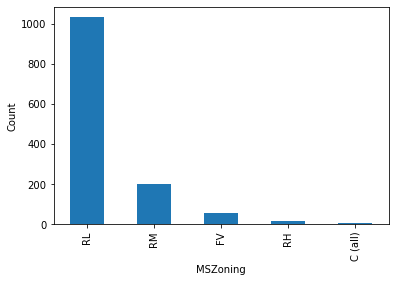

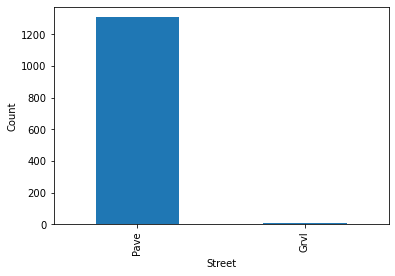

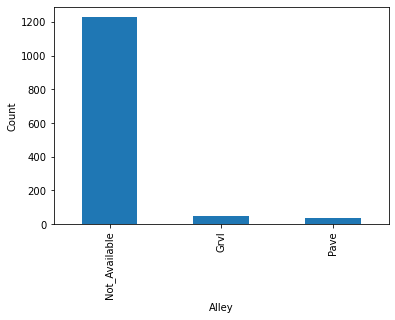

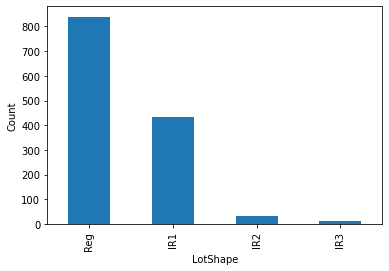

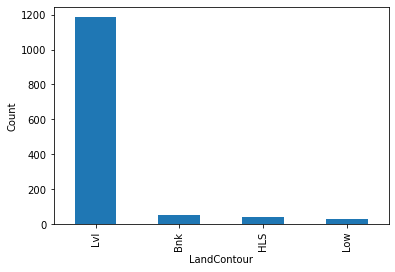

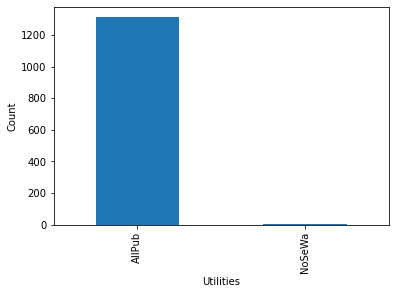

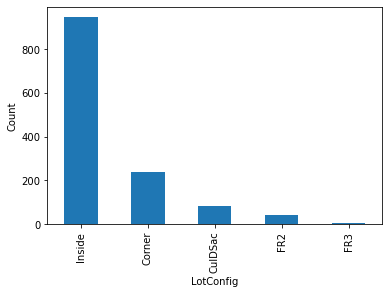

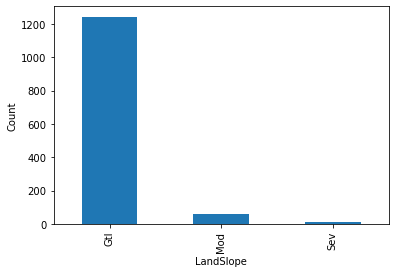

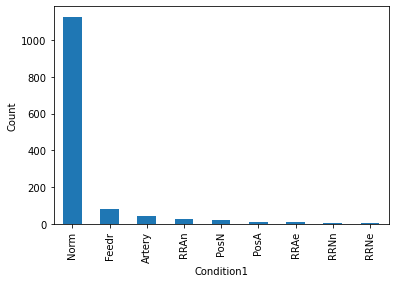

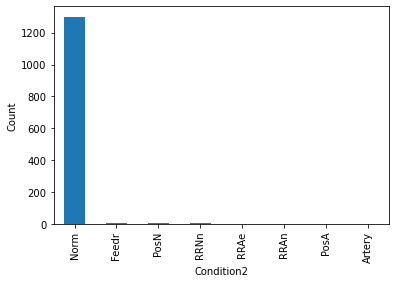

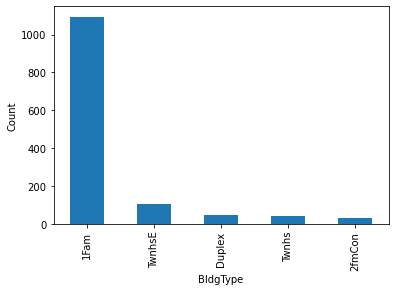

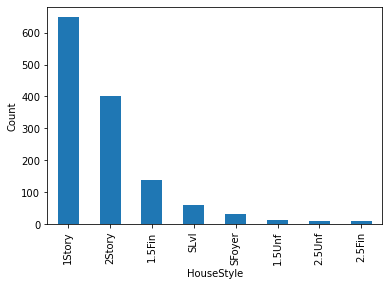

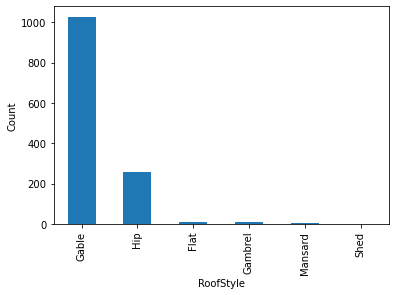

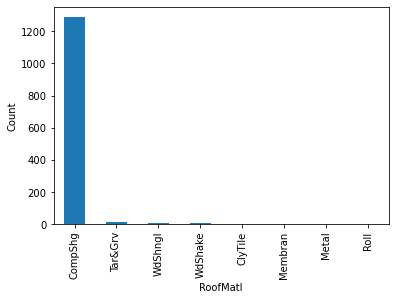

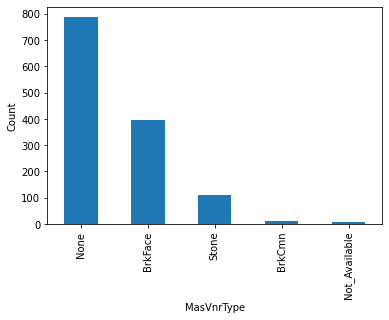

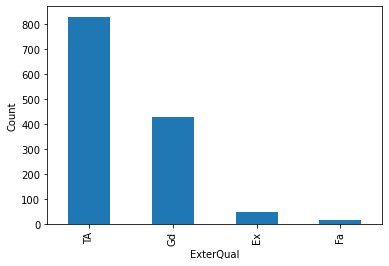

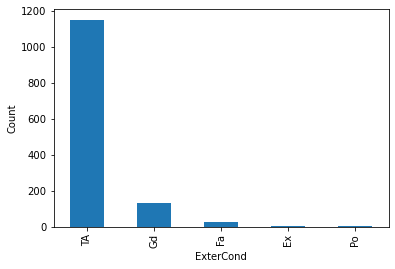

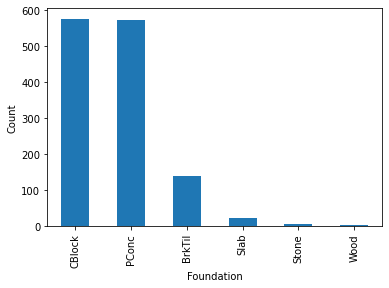

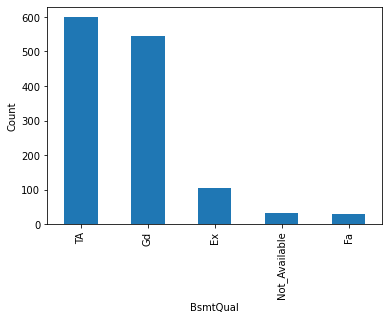

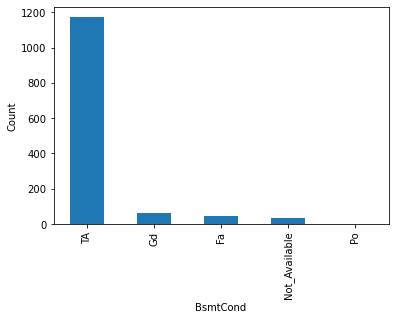

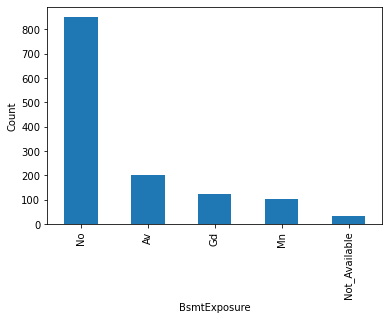

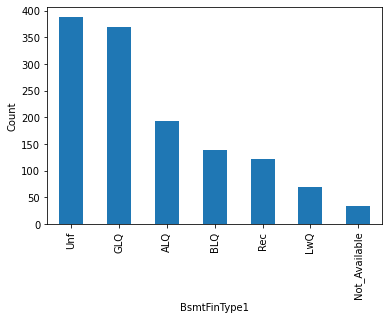

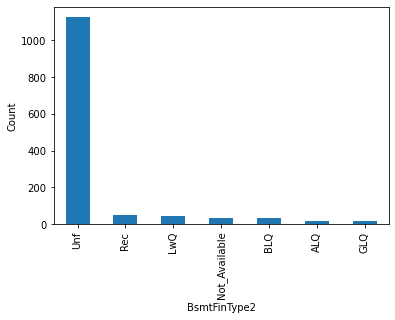

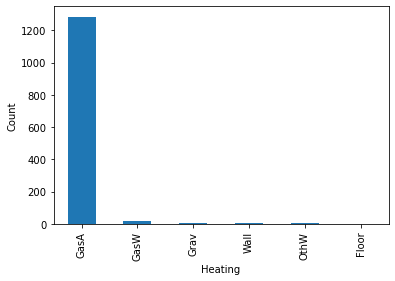

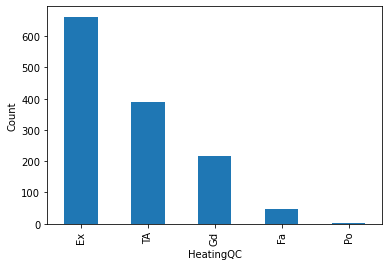

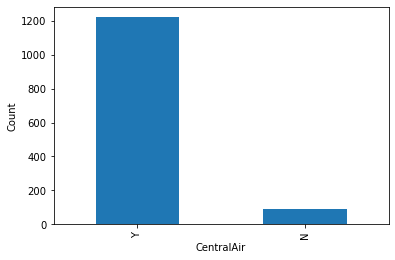

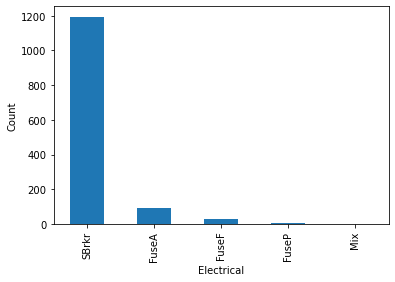

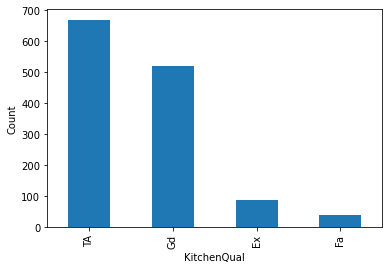

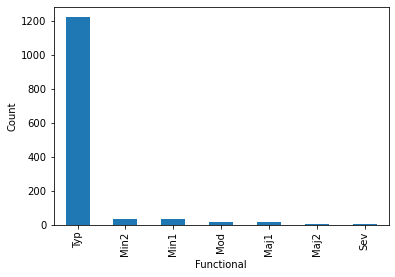

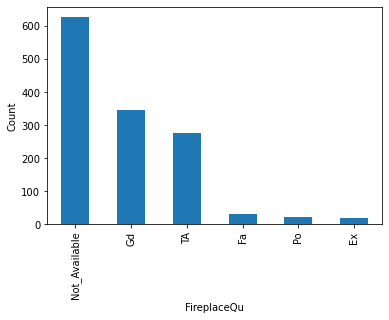

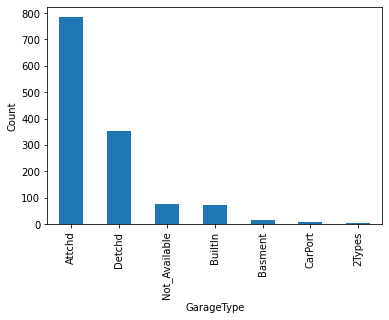

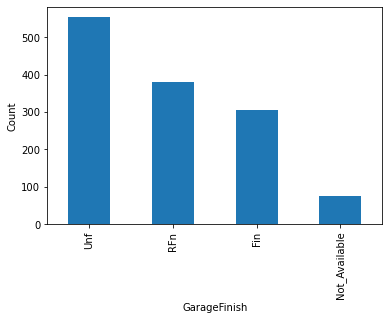

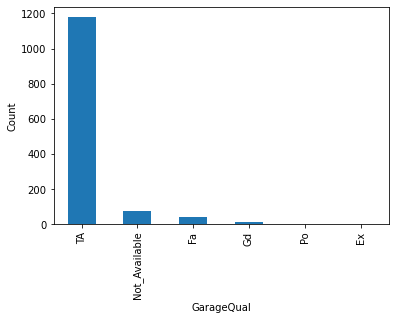

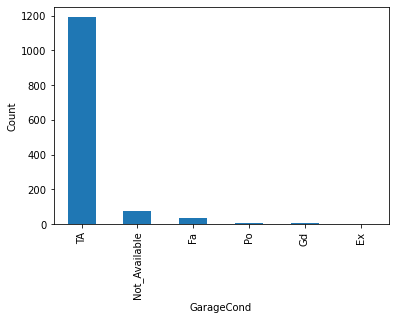

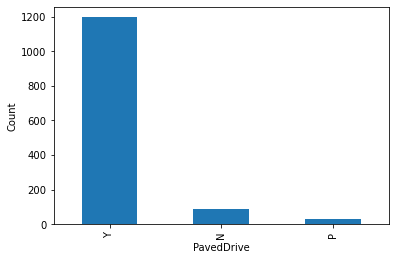

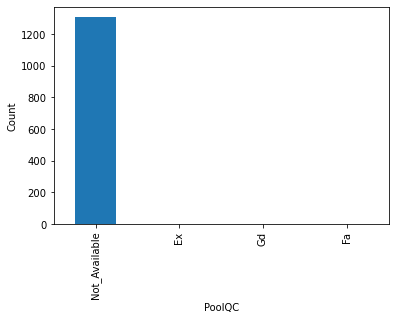

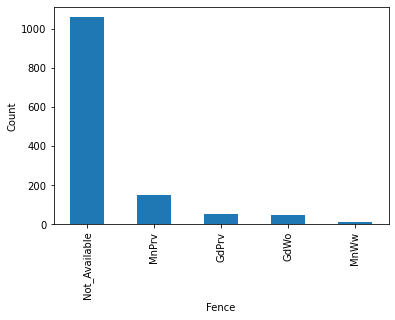

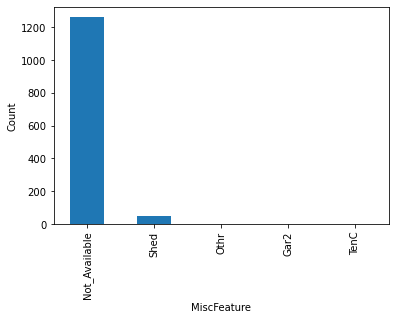

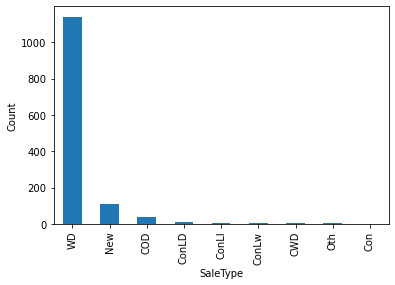

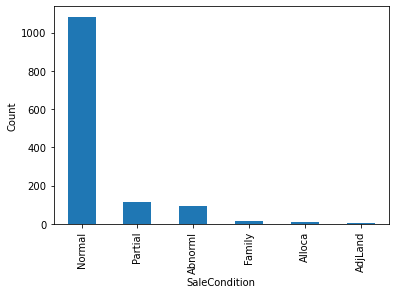

{'Alley',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Fence',
 'FireplaceQu',
 'Foundation',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'PavedDrive',
 'PoolQC',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities'}

In [15]:
#Plotting Bar Graphs for the Categorical Features
objectcolumns(x_train,1)

In [16]:
x_train.isnull().sum().sort_values()

Id                 0
Fireplaces         0
Functional         0
KitchenQual        0
KitchenAbvGr       0
                ... 
RoofStyle          0
ExterCond          0
SaleCondition      0
MasVnrArea         8
LotFrontage      234
Length: 76, dtype: int64

Handling Missng Values For Numerical Variables

In [17]:
x_train['LotFrontage'].fillna(x_train['LotFrontage'].mode().values[0],inplace=True)
x_train['MasVnrArea'].fillna(x_train['MasVnrArea'].mode().values[0],inplace=True)
x_train.isnull().sum().sort_values(ascending=False).head(20)


Id              0
FullBath        0
FireplaceQu     0
Fireplaces      0
Functional      0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
BsmtHalfBath    0
MSSubClass      0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
Electrical      0
CentralAir      0
HeatingQC       0
GarageType      0
GarageFinish    0
dtype: int64

#### To plot bar Graph of numerical Variables having less than 10 unique Features

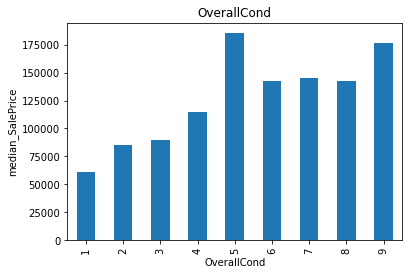

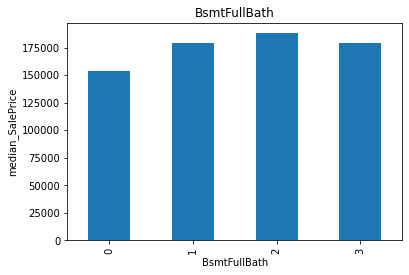

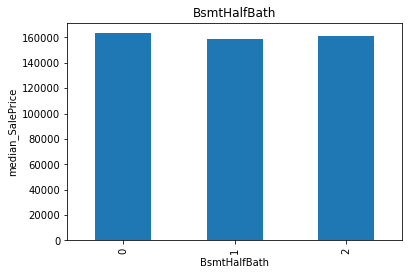

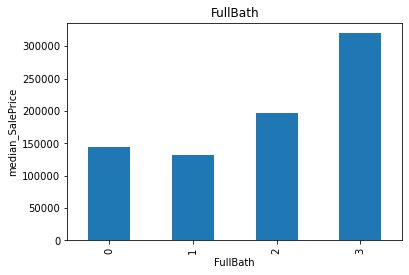

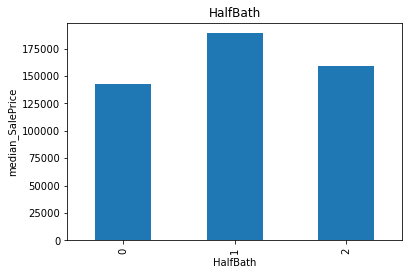

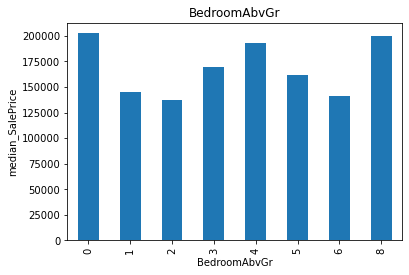

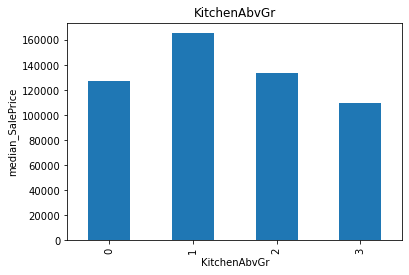

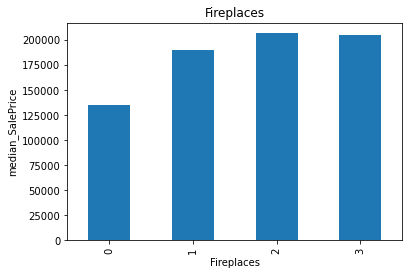

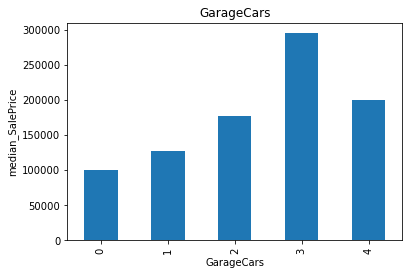

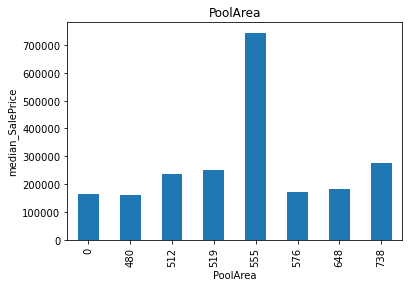

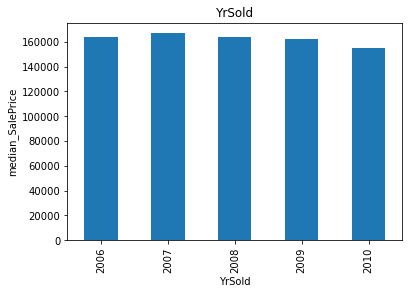

In [18]:
for i in x_train.columns:
    if x_train[i].dtype != 'O':
        if len(x_train[i].unique()) < 10:
            df.groupby(i)['SalePrice'].median().plot.bar()
            plt.title(i)
            plt.ylabel('median_SalePrice')
            plt.show()

#### To plot HistoGram Graph and measuring Skewness of numerical Variables having More than 10 unique Features

0.014696349240362857


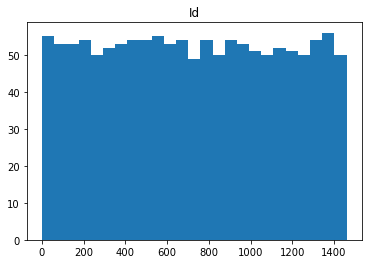

1.4005694761361116


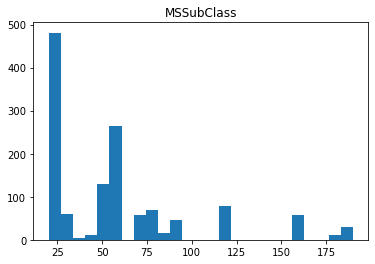

2.6239980310043345


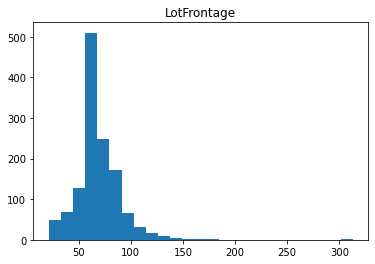

11.953971733350395


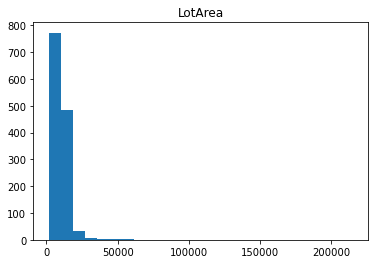

-0.5898399185318619


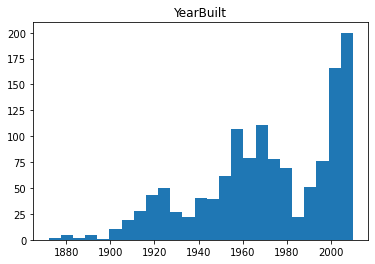

-0.4640328367287978


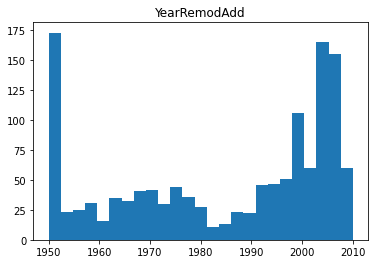

2.7910366581254


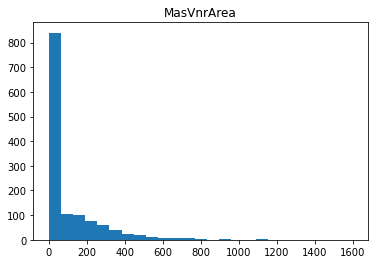

1.797564737978616


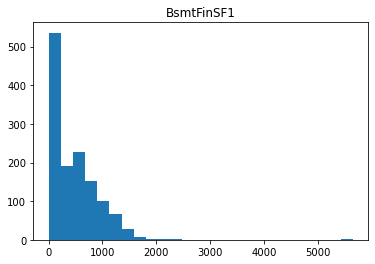

4.298514282857415


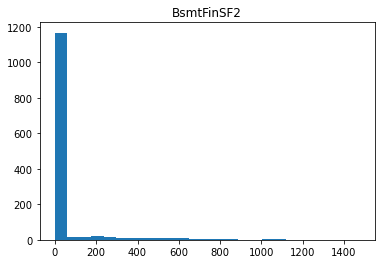

0.917759692826683


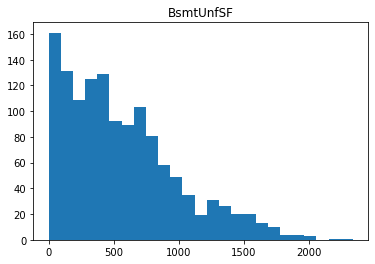

1.5946018967363436


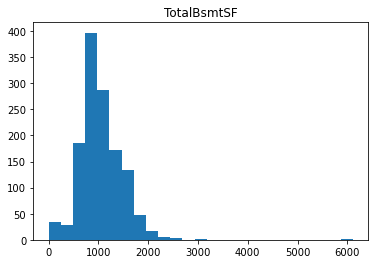

0.8203796164746912


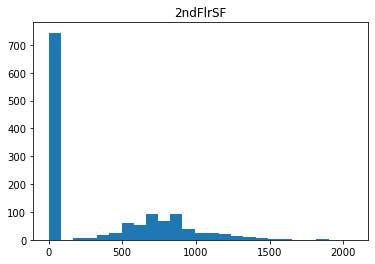

8.786035109731692


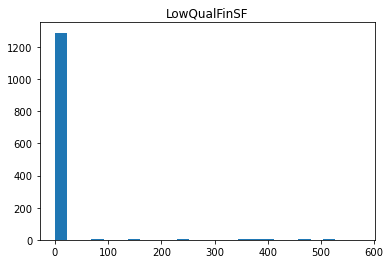

1.4300242355250024


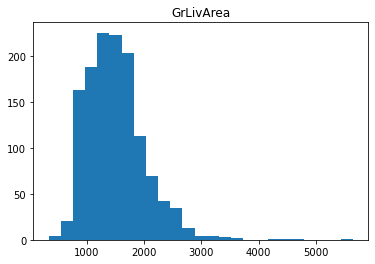

1.5731045691423462


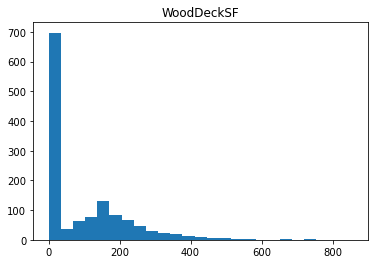

2.381710949941738


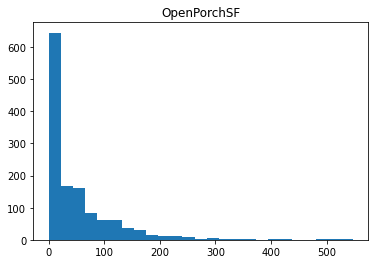

3.072847121709195


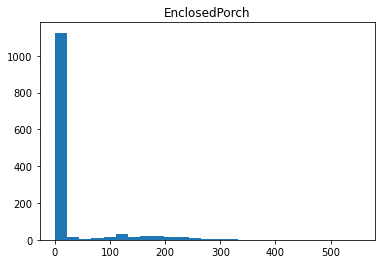

10.265724087094044


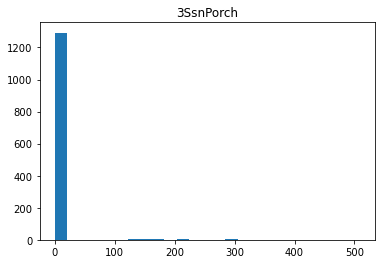

4.142323151575347


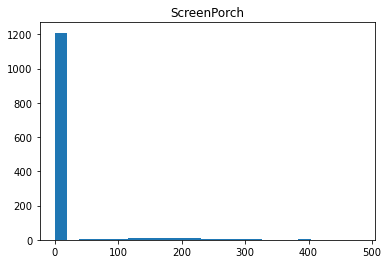

23.27382466642997


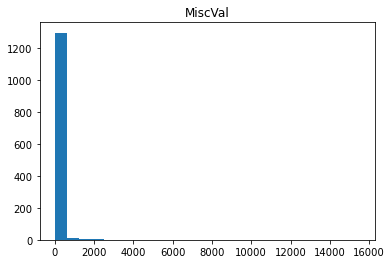

0.20543073143326182


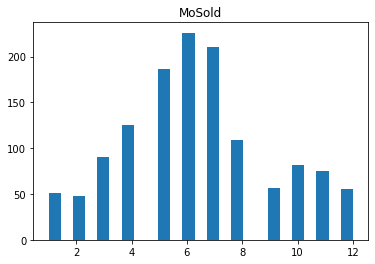

In [19]:

for i in x_train.columns:
    if x_train[i].dtype != 'O':
        if len(x_train[i].unique()) > 10:
            print(x_train[i].skew())
            plt.hist(x_train[i],bins=25)
            plt.title(i)
            plt.show()

1.976867338878498

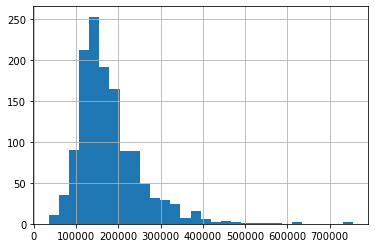

In [20]:
y_train.hist(bins=30)
y_train.skew()

**Now there are some features whick are having High Skewness Value, some are because of that particular feature not existing in that Record** <br>
**lets perform log operation on features**


In [21]:

x_train['log_MiscVal']= x_train['MiscVal'].replace(0,0.1)
x_train['log_MiscVal'] = np.log(x_train['log_MiscVal'])

x_train['log_LotArea']= x_train['LotArea'].replace(0,0.1)
x_train['log_LotArea'] = np.log(x_train['log_LotArea'])

x_train['log_LotFrontage']= x_train['LotFrontage'].replace(0,0.1)
x_train['log_LotFrontage'] = np.log(x_train['log_LotFrontage'])


x_train['log_MasVnrArea']= x_train['MasVnrArea'].replace(0,0.1)
x_train['log_MasVnrArea'] = np.log(x_train['log_MasVnrArea'])

x_train['log_OpenPorchSF']= x_train['OpenPorchSF'].replace(0,0.1)
x_train['log_OpenPorchSF'] = np.log(x_train['log_OpenPorchSF'])

x_train['log_WoodDeckSF']= x_train['WoodDeckSF'].replace(0,0.1)
x_train['log_WoodDeckSF'] = np.log(x_train['log_WoodDeckSF'])

logy_train=np.log(y_train)

x_train.drop(['MiscVal','LotArea','LotFrontage','MasVnrArea','OpenPorchSF','WoodDeckSF'],axis=1,inplace=True)

-0.05903691303640046


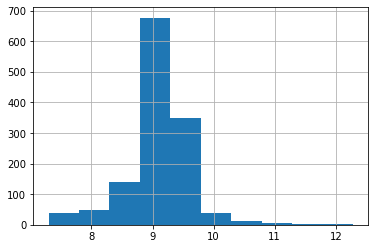

0.09592574088326773


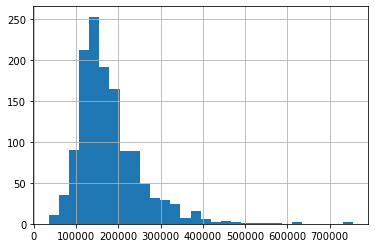

In [22]:
print(x_train['log_LotArea'].skew())
x_train['log_LotArea'].hist()
plt.show()
print(logy_train.skew())
y_train.hist(bins=30)
logy_train.skew()
plt.show()

As from the Above Example Skewnesss Has Decreased Significantly

In [23]:
x_train['Id']=df['Id']
x_train.sort_values('Id')

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,log_MiscVal,log_LotArea,log_LotFrontage,log_MasVnrArea,log_OpenPorchSF,log_WoodDeckSF
0,1,60,RL,Pave,Not_Available,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,854,0,1710,1,0,2,1,3,1,Gd,Typ,0,Not_Available,Attchd,RFn,2,TA,TA,Y,0,0,0,0,Not_Available,Not_Available,Not_Available,2,2008,WD,Normal,-2.302585,9.041922,4.174387,5.278115,4.110874,-2.302585
1,2,20,RL,Pave,Not_Available,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,0,0,1262,0,1,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,0,0,0,0,Not_Available,Not_Available,Not_Available,5,2007,WD,Normal,-2.302585,9.169518,4.382027,-2.302585,-2.302585,5.697093
2,3,60,RL,Pave,Not_Available,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,866,0,1786,1,0,2,1,3,1,Gd,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,0,0,0,0,Not_Available,Not_Available,Not_Available,9,2008,WD,Normal,-2.302585,9.328123,4.219508,5.087596,3.737670,-2.302585
3,4,70,RL,Pave,Not_Available,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,756,0,1717,1,0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,3,TA,TA,Y,272,0,0,0,Not_Available,Not_Available,Not_Available,2,2006,WD,Abnorml,-2.302585,9.164296,4.094345,-2.302585,3.555348,-2.302585
4,5,60,RL,Pave,Not_Available,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1053,0,2198,1,0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,3,TA,TA,Y,0,0,0,0,Not_Available,Not_Available,Not_Available,12,2008,WD,Normal,-2.302585,9.565214,4.430817,5.857933,4.430817,5.257495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,Pave,Not_Available,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,694,0,1647,0,0,2,1,3,1,TA,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,0,0,0,0,Not_Available,Not_Available,Not_Available,8,2007,WD,Normal,-2.302585,8.976768,4.127134,-2.302585,3.688879,-2.302585
1456,1457,20,RL,Pave,Not_Available,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,0,0,2073,1,0,2,0,3,1,TA,Min1,2,TA,Attchd,Unf,2,TA,TA,Y,0,0,0,0,Not_Available,MnPrv,Not_Available,2,2010,WD,Normal,-2.302585,9.486076,4.442651,4.779123,-2.302585,5.855072
1457,1458,70,RL,Pave,Not_Available,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1152,0,2340,0,0,2,0,4,1,Gd,Typ,2,G

In [24]:
x_train.index=x_train['Id']


In [25]:
x_train.drop('Id',axis=1,inplace=True)


In [26]:
x_train

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,log_MiscVal,log_LotArea,log_LotFrontage,log_MasVnrArea,log_OpenPorchSF,log_WoodDeckSF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1402,60,RL,Pave,Not_Available,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,759,Unf,0,80,839,GasA,Ex,Y,SBrkr,729,0,1593,1,0,2,1,3,1,TA,Typ,1,TA,Attchd,Fin,2,TA,TA,Y,0,0,0,0,Not_Available,Not_Available,Not_Available,4,2008,WD,Normal,-2.302585,8.911260,4.127134,-2.302585,4.317488,4.605170
403,30,RL,Pave,Not_Available,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1940,1997,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,672,672,GasA,Ex,Y,SBrkr,0,0,672,0,0,1,0,2,1,TA,Typ,0,Not_Available,Detchd,Unf,1,TA,TA,N,0,0,0,0,Not_Available,GdPrv,Not_Available,8,2008,WD,Normal,-2.302585,9.230143,4.094345,-2.302585,-2.302585,5.123964
795,60,RL,Pave,Not_Available,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1994,1996,Gable,CompShg,MetalSd,MetalSd,None,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,712,712,GasA,Ex,Y,SBrkr,809,0,1895,0,0,2,1,3,1,Gd,Typ,1,TA,Attchd,Fin,2,TA,TA,Y,0,0,0,0,Not_Available,Not_Available,Shed,10,2008,WD,Normal,6.214608,9.290260,4.094345,-2.302585,3.828641,4.962845
249,60,RL,Pave,Not_Available,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,840,840,GasA,Ex,Y,SBrkr,828,0,1668,0,0,2,1,3,1,Gd,Typ,0,Not_Available,Attchd,RFn,2,TA,TA,Y,0,0,0,0,Not_Available,Not_Available,Not_Available,9,2007,WD,Normal,-2.302585,9.334061,4.276666,4.615121,4.219508,4.969813
887,90,RL,Pave,Not_Available,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,Duplex,1Story,5,5,1959,2005,Gable,CompShg,MetalSd,MetalSd,BrkFace,TA,TA,CBlock,TA,TA,No,LwQ,528,Unf,0,1098,1626,GasA,Ex,Y,SBrkr,0,0,1712,0,0,2,0,4,2,TA,Typ,0,Not_Available,Attchd,Fin,2,TA,TA,Y,0,0,0,0,Not_Available,Not_Available,Not_Available,6,2006,WD,Family,-2.302585,9.035153,4.248495,4.804021,3.988984,5.605802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,20,RL,Pave,Not_Available,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1970,1970,Flat,Tar&Grv,Plywood,Plywood,None,TA,Gd,CBlock,TA,Gd,Gd,GLQ,778,Unf,0,499,1277,GasA,TA,Y,SBrkr,0,0,1277,1,0,1,0,2,1,TA,Typ,1,Po,Attchd,Unf,2,TA,TA,Y,0,0,176,0,Not_Available,GdWo,Not_Available,4,2007,WD,Normal,-2.302585,9.271247,4.442651,-2.302585,-2.302585,-2.302585
300,20,RL,Pave,Not_Available,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,8,1950,2004,Gable,CompShg,HdBoard,HdBoard,None,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,1092,1092,GasA,Ex,Y,SBrkr,0,0,1152,0,1,1,0,3,1,Gd,Typ,1,Gd,Attchd,Unf,1,TA,TA,Y,0,0,0,0,Not_Available,GdPrv,Not_Available,8,2009,WD,Family,-2.302585,9.546813,4.382027,-2.302585,3.583519,-2.302585
494,20,RL,Pave,Not_Available,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1960,1960,Gable,CompShg,BrkFace,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,BLQ,374,LwQ,532,363,1269,GasA,TA,Y,FuseA,0

In [27]:
# Nominalizing the Labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in x_train:
    if x_train[i].dtype == 'O':
        x_train[i] = le.fit_transform(x_train[i])


In [28]:
x_train

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,log_MiscVal,log_LotArea,log_LotFrontage,log_MasVnrArea,log_OpenPorchSF,log_WoodDeckSF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1402,60,3,1,1,0,3,0,4,0,8,2,2,0,5,6,5,2004,2004,1,1,11,13,2,3,4,2,4,4,3,2,759,6,0,80,839,1,0,1,4,729,0,1593,1,0,2,1,3,1,3,6,1,5,1,0,2,5,5,2,0,0,0,0,3,4,1,4,2008,8,4,-2.302585,8.911260,4.127134,-2.302585,4.317488,4.605170
403,30,3,1,1,3,3,0,4,0,19,2,2,0,2,5,8,1940,1997,1,1,12,14,2,3,4,2,4,4,3,6,0,6,0,672,672,1,0,1,4,0,0,672,0,0,1,0,2,1,3,6,0,3,5,3,1,5,5,0,0,0,0,0,3,0,1,8,2008,8,4,-2.302585,9.230143,4.094345,-2.302585,-2.302585,5.123964
795,60,3,1,1,0,3,0,0,0,8,2,2,0,5,7,5,1994,1996,1,1,7,8,2,2,4,2,2,4,3,6,0,6,0,712,712,1,0,1,4,809,0,1895,0,0,2,1,3,1,2,6,1,5,1,0,2,5,5,2,0,0,0,0,3,4,3,10,2008,8,4,6.214608,9.290260,4.094345,-2.302585,3.828641,4.962845
249,60,3,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,11,13,1,2,4,2,2,4,3,6,0,6,0,840,840,1,0,1,4,828,0,1668,0,0,2,1,3,1,2,6,0,3,1,2,2,5,5,2,0,0,0,0,3,4,1,9,2007,8,4,-2.302585,9.334061,4.276666,4.615121,4.219508,4.969813
887,90,3,1,1,3,3,0,0,0,12,2,2,2,2,5,5,1959,2005,1,1,7,8,1,3,4,1,4,4,3,3,528,6,0,1098,1626,1,0,1,4,0,0,1712,0,0,2,0,4,2,3,6,0,3,1,0,2,5,5,2,0,0,0,0,3,4,1,6,2006,8,3,-2.302585,9.035153,4.248495,4.804021,3.988984,5.605802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,20,3,1,1,3,3,0,4,0,12,2,2,0,2,7,5,1970,1970,0,5,8,10,2,3,2,1,4,1,1,2,778,6,0,499,1277,1,4,1,4,0,0,1277,1,0,1,0,2,1,3,6,1,4,1,3,2,5,5,2,0,0,176,0,3,1,1,4,2007,8,4,-2.302585,9.271247,4.442651,-2.302585,-2.302585,-2.302585
300,20,3,1,1,3,3,0,4,0,6,2,2,0,2,6,8,1950,2004,1,1,6,6,2,3,2,1,4,4,3,6,0,6,0,1092,1092,1,0,1,4,0,0,1152,0,1,1,0,3,1,2,6,1,2,1,3,1,5,5,2,0,0,0,0,3,0,1,8,2009,8,3,-2.302585,9.546813,4.382027,-2.302585,3.583519,-2.302585
494,20,3,1,1,3,3,0,4,0,12,2,2,0,2,5,6,1960,1960,1,1,3,14,2,3,4,1,4,4,3,1,374,3,532,363,1269,1,4,1,0,0,0,1269,0,0,1,1,3,1,3,6,1,1,5,3,1,5,5,2,0,0,0,0,3,4,1,6,2008,8,4,-2.302585,8.978534,4.248495,-2.302585,-2.302585,-2.302585


## 3.Model Training

In [29]:
 model = XGBRegressor()

In [30]:
model.fit(x_train,logy_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
Predictedvalue = model.predict(x_train)
Predictedvalue=np.exp(Predictedvalue)

In [32]:
from sklearn import metrics
score_1=metrics.r2_score(y_train,Predictedvalue)

# mean ABsolute Error

score_2 = metrics.mean_absolute_error(y_train,Predictedvalue)

print(score_1,score_2)

0.9995241926564036 1134.7629405679224


In [33]:
Adjusted_rsquare = 1-(((1-score_1)*(1314-1))/(1314-75-1))
Adjusted_rsquare

0.999495367494231

In [34]:
x_train.shape

(1314, 75)

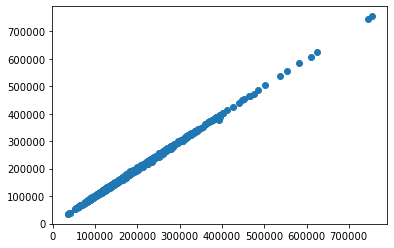

In [35]:
plt.scatter(y_train,Predictedvalue)

## 4.Model Testing

In [36]:
x_test.index=x_test['Id']
x_test.drop('Id',axis=1,inplace=True)

In [37]:
x_test['MiscFeature'].fillna('empty',inplace=True)   # Miscellaneous feature are not Present

x_test['GarageType'].fillna('empty',inplace=True)   # Since the count of Emmpty values are same Cant be Coincidence
x_test['GarageCond'].fillna('empty',inplace=True)
x_test['GarageQual'].fillna('empty',inplace=True)
x_test['GarageFinish'].fillna('empty',inplace=True)

x_test['Fence'].fillna('empty',inplace=True)     # assuming NO Fence 
x_test['MiscFeature'].fillna('empty',inplace=True)   # Miscellaneous feature are not Present

x_test['BsmtCond'].fillna('empty',inplace=True)   # Since the count of Emmpty values are equal
x_test['BsmtExposure'].fillna('empty',inplace=True)   
x_test['BsmtFinType1'].fillna('empty',inplace=True)   
x_test['BsmtFinType2'].fillna('empty',inplace=True)   
x_test['BsmtQual'].fillna('empty',inplace=True)  

x_test['FireplaceQu'] = np.where(((pd.isnull(x_test['FireplaceQu'])) & (x_test['Fireplaces']==0)),'Empty',x_test['FireplaceQu'])    #  replacing Empty Where Fire Places equal t0 0 

x_test['MasVnrType'].fillna('empty',inplace=True)      # replacing with Empty Value

x_test['Electrical'].fillna(x_test['Electrical'].mode().values[0],inplace=True)     # filling with Mode Value since the House Cannot be with the Electrical System so assigning the Common type of Electrical System


x_test['PoolQC'] = np.where(((pd.isnull(x_test['PoolQC'])) & (x_test['PoolArea']==0)),'Empty',x_test['PoolQC'])  #  if the Pool Area is Zero then pool Quality will be empty


x_test['Alley'].fillna('empty',inplace=True)      # replacing with Empty Value since the % of missing Vlaues is High assuming it cannot be mistake so creating seperate Category



In [38]:
x_test.isnull().sum().sort_values(ascending=False).head(20)

LotFrontage     25
MSSubClass       0
FullBath         0
FireplaceQu      0
Fireplaces       0
Functional       0
KitchenQual      0
KitchenAbvGr     0
BedroomAbvGr     0
HalfBath         0
BsmtHalfBath     0
GarageFinish     0
BsmtFullBath     0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
Electrical       0
CentralAir       0
GarageType       0
GarageCars       0
dtype: int64

In [39]:
x#for continuous Variables
x_test['LotFrontage'].fillna(x_test['LotFrontage'].mode().values[0],inplace=True)
x_test['MasVnrArea'].fillna(x_test['MasVnrArea'].mode().values[0],inplace=True)
x_test.isnull().sum().sort_values(ascending=False).head(20)


MSSubClass      0
GarageFinish    0
FireplaceQu     0
Fireplaces      0
Functional      0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
Electrical      0
CentralAir      0
GarageType      0
GarageCars      0
Heating         0
dtype: int64

In [40]:

for i in x_test:
    if x_test[i].dtype == 'O':
        x_test[i] = le.fit_transform(x_test[i])



In [41]:


x_test['log_MiscVal']= x_test['MiscVal'].replace(0,0.1)
x_test['log_MiscVal'] = np.log(x_test['log_MiscVal'])

x_test['log_LotArea']= x_test['LotArea'].replace(0,0.1)
x_test['log_LotArea'] = np.log(x_test['log_LotArea'])

x_test['log_LotFrontage']= x_test['LotFrontage'].replace(0,0.1)
x_test['log_LotFrontage'] = np.log(x_test['log_LotFrontage'])


x_test['log_MasVnrArea']= x_test['MasVnrArea'].replace(0,0.1)
x_test['log_MasVnrArea'] = np.log(x_test['log_MasVnrArea'])

x_test['log_OpenPorchSF']= x_test['OpenPorchSF'].replace(0,0.1)
x_test['log_OpenPorchSF'] = np.log(x_test['log_OpenPorchSF'])

x_test['log_WoodDeckSF']= x_test['WoodDeckSF'].replace(0,0.1)
x_test['log_WoodDeckSF'] = np.log(x_test['log_WoodDeckSF'])



In [42]:
x_test.drop(['MiscVal','LotArea','LotFrontage','MasVnrArea','OpenPorchSF','WoodDeckSF'],axis=1,inplace=True)

In [43]:
predicted_test = model.predict(x_test)

In [44]:
predicted_test=np.exp(predicted_test)

In [45]:

score_1=metrics.r2_score(y_test,predicted_test)
score_1

0.8694156178631816

In [46]:
Adjusted_rsquare = 1-(((1-score_1)*(1314-1))/(1314-75-1))
Adjusted_rsquare

0.861504609252308

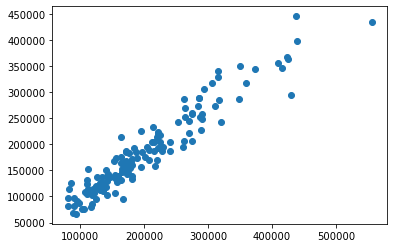

In [47]:
plt.scatter(y_test,predicted_test)